In [1]:
%autosave 10

Autosaving every 10 seconds


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
df = pd.read_csv("../data/laptops.csv")

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [6]:
cols_to_use = ['ram', 'storage', 'screen', 'final_price']

In [7]:
df = df[cols_to_use].copy()

# Check Final Price Dist

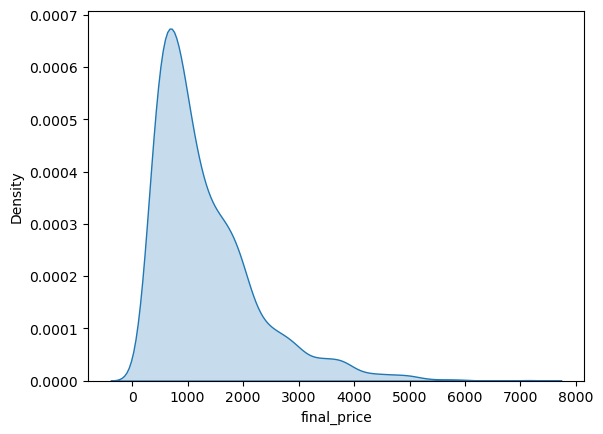

In [8]:
sns.kdeplot(df['final_price'], fill=True)
plt.show()

# Q1

In [9]:
df[cols_to_use].isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

# Q2

In [10]:
df['ram'].describe()

count    2160.000000
mean       15.413889
std         9.867815
min         4.000000
25%         8.000000
50%        16.000000
75%        16.000000
max       128.000000
Name: ram, dtype: float64

# Q3

In [11]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
print(f"Train size: {n_train}")
print(f"Validation size: {n_val}")
print(f"Test size: {n_test}")
print(f"Check {n}, {n_train+n_val+n_test}")

Train size: 1296
Validation size: 432
Test size: 432
Check 2160, 2160


In [12]:
def split_data_by_seed(seed, n):
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)
    # Define Datasets
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]
    return df_train, df_val, df_test

In [13]:
df_train, df_valid, df_test = split_data_by_seed(seed=42, n=n)

# Fill missing values 0

In [14]:
feats = ['ram', 'storage', 'screen']
target = ['final_price']

In [15]:
def prepare_df(df, col, fill=0):
    data = df.copy()
    data[col] = data[col].fillna(fill)
    return data

In [16]:
def process_data(df, feats, target, fill=0):
    df = prepare_df(df, 'screen', fill=fill)
    X = df[feats].values
    y = df[target].values
    return X, y

In [17]:
# Train Model
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [18]:
X_train, y_train = process_data(df_train, feats, target, fill=0)
X_valid, y_valid = process_data(df_valid, feats, target, fill=0)

In [19]:
w0, w = train_linear_regression(X_train, y_train)

In [20]:
def predict(X, w, w0):
    return w0 + X.dot(w)

In [21]:
# Evaluate method 1
y_pred_method_1 = predict(X_valid, w, w0)

In [22]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [23]:
np.round(rmse(y_valid, y_pred_method_1), 2)

597.36

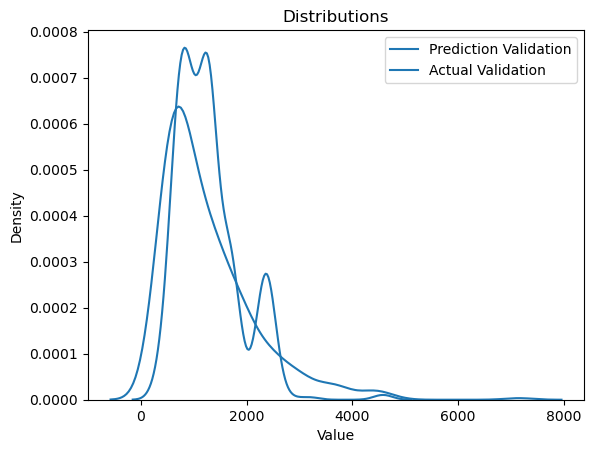

In [24]:
sns.kdeplot(y_pred_method_1, color='blue', label='Prediction Validation')
sns.kdeplot(y_valid, color='green', label='Actual Validation')

# Adding labels and title
plt.title('Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show plot
plt.show()

# Fill missing values mean

In [25]:
mean_screen = df_train['screen'].mean()

In [26]:
X_train, y_train = process_data(df_train, feats, target, fill=mean_screen)
X_valid, y_valid = process_data(df_valid, feats, target, fill=mean_screen)

In [27]:
w0, w = train_linear_regression(X_train, y_train)

In [28]:
# Evaluate method 2
y_pred_method_2 = predict(X_valid, w, w0)

In [29]:
np.round(rmse(y_valid, y_pred_method_2), 2)

600.27

# Q4

In [30]:
X_train, y_train = process_data(df_train, feats, target, fill=0)
X_valid, y_valid = process_data(df_valid, feats, target, fill=0)

In [31]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [32]:
r_options = [0, 0.01, 0.1, 1, 5, 10, 100]

In [33]:
check_lst = []
for r in r_options:
    w0, w = train_linear_regression_reg(X_train, y_train, r)
    y_pred = predict(X_valid, w, w0)
    score = np.round(rmse(y_valid, y_pred), 2)
    print(f"RMSE for regularization param {r}: {score} \n")
    check_lst.append((r, score))

RMSE for regularization param 0: 597.36 

RMSE for regularization param 0.01: 597.36 

RMSE for regularization param 0.1: 597.35 

RMSE for regularization param 1: 597.21 

RMSE for regularization param 5: 597.01 

RMSE for regularization param 10: 597.06 

RMSE for regularization param 100: 597.9 



In [34]:
sorted(check_lst, key=lambda x: x[1])

[(5, 597.01),
 (10, 597.06),
 (1, 597.21),
 (0.1, 597.35),
 (0, 597.36),
 (0.01, 597.36),
 (100, 597.9)]

# Q5

In [35]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [36]:
scores_seeds = []
n = len(df)
for seed in seeds:
    df_train, df_val, _  = split_data_by_seed(seed, n)
    X_train, y_train = process_data(df_train, feats, target)
    X_valid, y_valid = process_data(df_val, feats, target)
    w0, w = train_linear_regression(X_train, y_train)
    y_pred = predict(X_valid, w, w0)
    score = rmse(y_valid, y_pred)
    scores_seeds.append(score)

In [37]:
np.round(np.std(scores_seeds), 3)

29.176

# Q6

In [38]:
df_train, df_val, df_test  = split_data_by_seed(9, n)

In [39]:
df_train_new = pd.concat([df_train, df_val])

In [40]:
X_train, y_train = process_data(df_train_new, feats, target)
X_test, y_test = process_data(df_test, feats, target)

In [41]:
w0, w = train_linear_regression_reg(X_train, y_train, r=0.001)

In [42]:
y_pred = predict(X_test, w, w0)

In [43]:
rmse(y_test, y_pred).round(2)

608.61